## Import libraries

In [2]:
# run this to install these packages
# pip install -r requirements.txt 

# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation
import os # for file management
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rxr
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu
from pyproj import Proj, Transformer, CRS
import seaborn as sns
from shapely.geometry import Point
import pystac_client
import planetary_computer 
from odc.stac import stac_load
from tqdm import tqdm

# Machine Learning
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Get the absolute path of the project's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Change working directory
os.chdir(project_root)
# Check the current working directory
os.getcwd()

'/Users/masonphung/Desktop/data science/data_projects/challenge_ey2025'

In [4]:
from src.data_processing import SatelliteDataExtractor, SatelliteDataManipulator, WeatherDataProcessor, drop_duplicate

As the notebook is stored in `notebooks` directory, we need to change the working directory to the root to make it easier to import the modules or datasets

## II. Data processing
### A. Import sentinel-2 and Landsat data

We'll get the data from source, wrangle the imported data, then output them as `.tiff` files for further processing.

In [ ]:
processor = SatelliteDataExtractor(
    lower_left=(40.75, -74.01), 
    upper_right=(40.88, -73.86), 
    time_window="2021-06-01/2021-09-01"
)

# Process and save Sentinel-2 data
processor.process_data(
    dataset_type="sentinel2", 
    filename="data/interim/Sen2.tiff", 
    bands=["B01", "B02", "B03", "B04","B06", "B08", "B11", "B12"], 
    # bands=["B01", "B02", "B03", "B04","B05", "B06","B07","B8A", "B08", "B11", "B12"], 
)

# Process and save Landsat data
processor.process_data(
    dataset_type="landsat", 
    filename="data/interim/Landsat_LST.tiff", 
    bands=["lwir11"], 
    scene=2
)

Processing Sentinel-2 data...
Number of scenes that touch our region: 10
Data loaded!
Using Bounds: (-74.01, 40.75, -73.86, 40.88), Time Window: 2021-06-01/2021-09-01
Calculating the bands median...
Preparing data for saving...
Data saved: data/interim/Sen2.tiff

Processing Landsat data...
Number of scenes that touch our region: 8
Data loaded!
Using Bounds: (-74.01, 40.75, -73.86, 40.88), Time Window: 2021-06-01/2021-09-01
Scaling landsat data...
Preparing data for saving...
Data saved: data/interim/Landsat_LST.tiff



### B. Data manipulation for model training

<h4 style="color:rgb(255, 255, 0)">1. Map satelitte data with the coordinates in the training file</h4>

Load 2 `.tiff` files of Sentinel-2 and Landsat data, then map them with the coordinates in the training file. Later combine the ground data (building footprint) with the mapped satellite data.

In [7]:
band_mappings = {
    "B01": ("sentinel", 1),
    "B02": ("sentinel", 2),
    "B03": ("sentinel", 3),
    "B04": ("sentinel", 4),
    #"B05": ("sentinel", 5),
    "B06": ("sentinel", 5),
    #"B07": ("sentinel", 7),
    #"B8A": ("sentinel", 8),
    "B08": ("sentinel", 6),
    "B11": ("sentinel", 7),
    "B12": ("sentinel", 8),
    "L11": ("landsat", 1)
}

buffer_sizes = [0, 10, 20, 30, 50, 100]

# Run the pipeline
manipulator = SatelliteDataManipulator(
    sen2_tiff_path="data/interim/Sen2.tiff",
    land_tiff_path="data/interim/Landsat_LST.tiff",
    ground_df_path="data/raw/Training_data_uhi_index_2025-02-18.csv",
    band_mappings=band_mappings,
    buffer_distances=[0],
)

sat_data = manipulator.map_satellite_data()
sat_data = manipulator.calc_band_indices(sat_data)

Loading GeoTIFF data...
Data loaded!
Loading ground truth data...
Data loaded!


Mapping values: 100%|██████████| 11229/11229 [00:25<00:00, 443.72it/s]


Load ground data and combine with the sentinel-2 dataset

In [169]:
# Load ground dataset
ground_df = pd.read_csv("data/interim/ground_df.csv")
# Simply use `pd.concat` as we've already get the data based on each lon & lat of ground_df
satground_df = pd.concat([ground_df,sat_data], axis=1)
satground_df.head()

,Longitude,Latitude,datetime,UHI Index,building_coverage,building_count,B01,B02,B03,B04,...,B08,B11,B12,L11,NDVI_buffer0m,NDBI_buffer0m,NDWI_buffer0m,EVI_buffer0m,SAVI_buffer0m,NBAI_buffer0m
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,0.000006,44,983.8765411868803,973.3641776902218,1083.5735594048642,1137.8917391357231,...,1902.6756313790333,1662.7471565882324,1336.9106988746425,38.451903312133595,0.251527,-0.067293,-0.274291,1.336292,0.377228,0.223767
1,-73.909187,40.813045,24-07-2021 15:53,1.030289,0.000006,44,983.8765411868803,973.3641776902218,1083.5735594048642,1137.8917391357231,...,1902.6756313790333,1662.7471565882324,1336.9106988746425,38.451903312133595,0.251527,-0.067293,-0.274291,1.336292,0.377228,0.223767
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,0.000006,44,903.8314156683374,653.4355169378344,818.7226412134626,778.6291362784817,...,2209.0174709765715,1535.0932964197837,1178.8241402830492,38.003281490645975,0.478768,-0.179996,-0.459186,1.805111,0.718031,0.102561
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,0.000006,44,904.1785648493687,627.612048284474,757.3586785833479,725.4839044314942,...,2137.630746778734,1505.8960152264274,1129.08998735382,38.003281490645975,0.493221,-0.173386,-0.476780,1.978413,0.739702,0.104210
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,0.000006,44,961.160094049933,670.0536152776679,776.6655776581048,729.4167136999156,...,2087.1113392147126,1595.8422048029759,1215.571295303761,37.569030962026204,0.482045,-0.133390,-0.457594,2.358403,0.722940,0.147861


In [6]:
satground_df.describe()

,Longitude,Latitude,UHI Index,building_coverage,NDVI,NDBI,NDWI,EVI,SAVI,NBAI
count,11229.000000,11229.000000,11229.000000,1.122900e+04,11229.000000,11229.000000,11229.000000,1.122900e+04,1.122900e+04,11229.000000
mean,-73.933927,40.808800,1.000001,8.097158e-06,0.206853,0.009703,-0.225783,1.438129e+09,3.108649e-01,0.299228
std,0.028253,0.023171,0.016238,3.685329e-06,0.206192,0.132000,0.175793,1.325144e+10,3.085640e-01,0.146793
min,-73.994457,40.758792,0.956122,2.370098e-08,-0.164700,-0.443110,-0.806583,-7.650000e+10,1.500000e-08,-0.272472
25%,-73.955703,40.790905,0.988577,5.875661e-06,0.053281,-0.063419,-0.309578,3.708699e-01,7.990905e-02,0.233636
50%,-73.932968,40.810688,1.000237,8.173191e-06,0.129202,0.024390,-0.165601,8.793055e-01,1.937807e-01,0.327112
75%,-73.909647,40.824515,1.011176,1.038176e-05,0.295107,0.096386,-0.095206,1.795891e+00,4.425934e-01,0.397325
max,-73.879458,40.859497,1.046036,1.634728e-05,0.882879,0.558525,0.187701,2.910000e+11,1.324145e+00,0.746920


*We now have `satground_data` - a combination of the ground UHI data and the sentinel-2 indices data*

<h4 style="color:rgb(255, 255, 0)">2. Map `NY_Mesonet_Weather` data with our `satground_data`</h4>

Load `New York Mesonet Weather` data with the 2 sheets of 2 different locations, merge them together, wrangle, then combine with the `satground_data`.

In [170]:
weather_processor = WeatherDataProcessor(
    weather_df_path = "data/raw/NY_Mesonet_Weather.xlsx",
    satground_df=satground_df
)
weather_processor.classify_weather_data()
uhi_data = weather_processor.process_weather_data()

Loading weather data...
Mapped location name with the corresponding lat & lon
Processing weather data...
Processing completed!
Successfully merged satground and weather dataset! Let's take a look at the final dataset:


Drop duplicates

In [171]:
uhi_data = drop_duplicate(uhi_data)

In [172]:
uhi_data

,Longitude,Latitude,datetime,UHI Index,building_coverage,building_count,B01,B02,B03,B04,...,NDWI_buffer0m,EVI_buffer0m,SAVI_buffer0m,NBAI_buffer0m,location,Air Temp at Surface [degC],Relative Humidity [percent],Avg Wind Speed [m/s],Wind Direction [degrees],Solar Flux [W/m^2]
0,-73.977157,40.771555,2021-07-24 15:01:00,0.975234,4.248421e-07,7,497.684133,1048.144815,1214.119993,1309.190101,...,-0.267433,0.944094,0.348092,0.263109,Manhattan,26.1,51.1,4.1,139,140
1,-73.910167,40.803775,2021-07-24 15:01:00,1.000718,2.952757e-06,20,1306.462846,1342.490838,1467.690519,1528.572929,...,-0.050826,0.330418,0.045800,0.391160,Manhattan,26.1,51.1,4.1,139,140
2,-73.910268,40.803817,2021-07-24 15:01:00,1.000718,2.952757e-06,20,1365.268570,1326.530259,1397.509001,1532.360054,...,-0.080552,0.309536,0.051972,0.337912,Manhattan,26.1,51.1,4.1,139,140
3,-73.978742,40.771675,2021-07-24 15:01:00,0.975234,1.083310e-05,22,503.310770,518.144441,651.960854,533.770987,...,-0.631996,2.668288,1.032318,-0.069964,Manhattan,26.1,51.1,4.1,139,140
4,-73.978453,40.771677,2021-07-24 15:01:00,0.970907,4.248421e-07,7,477.914724,405.595662,526.303878,406.072733,...,-0.680297,2.729525,1.115797,-0.049435,Manhattan,26.1,51.1,4.1,139,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11223,-73.979088,40.771655,2021-07-24 15:59:00,0.975234,1.083310e-05,22,642.350249,1000.734028,1049.912777,1171.531188,...,-0.173539,0.786058,0.179863,0.274939,Manhattan,26.8,46.7,3.4,196,605
11224,-73.979060,40.771682,2021-07-24 15:59:00,0.975234,1.083310e-05,22,642.350249,1000.734028,1049.912777,1171.531188,...,-0.173539,0.786058,0.179863,0.274939,Manhattan,26.8,46.7,3.4,196,605
11225,-73.979027,40.771695,2021-07-24 15:59:00,0.975234,1.083310e-05,22,583.318635,698.080971,802.626734,807.955570,...,-0.412922,1.818554,0.615148,0.131789,Manhattan,26.8,46.7,3.4,196,605
11227,-73.905072,40.844538,2021-07-24 15:59:00,1.000838,7.459108e-06,84,1080.125142,1271.195267,1197.730408,1234.798035,...,-0.145330,-1.783145,0.195537,0.372812,Manhattan,26.8,46.7,3.4,196,605


<h4 style="color:rgb(255, 255, 0)">3. Correlation check</h4>

Text(0.5, 1.0, 'Correlation between the variables of the UHI dataset')

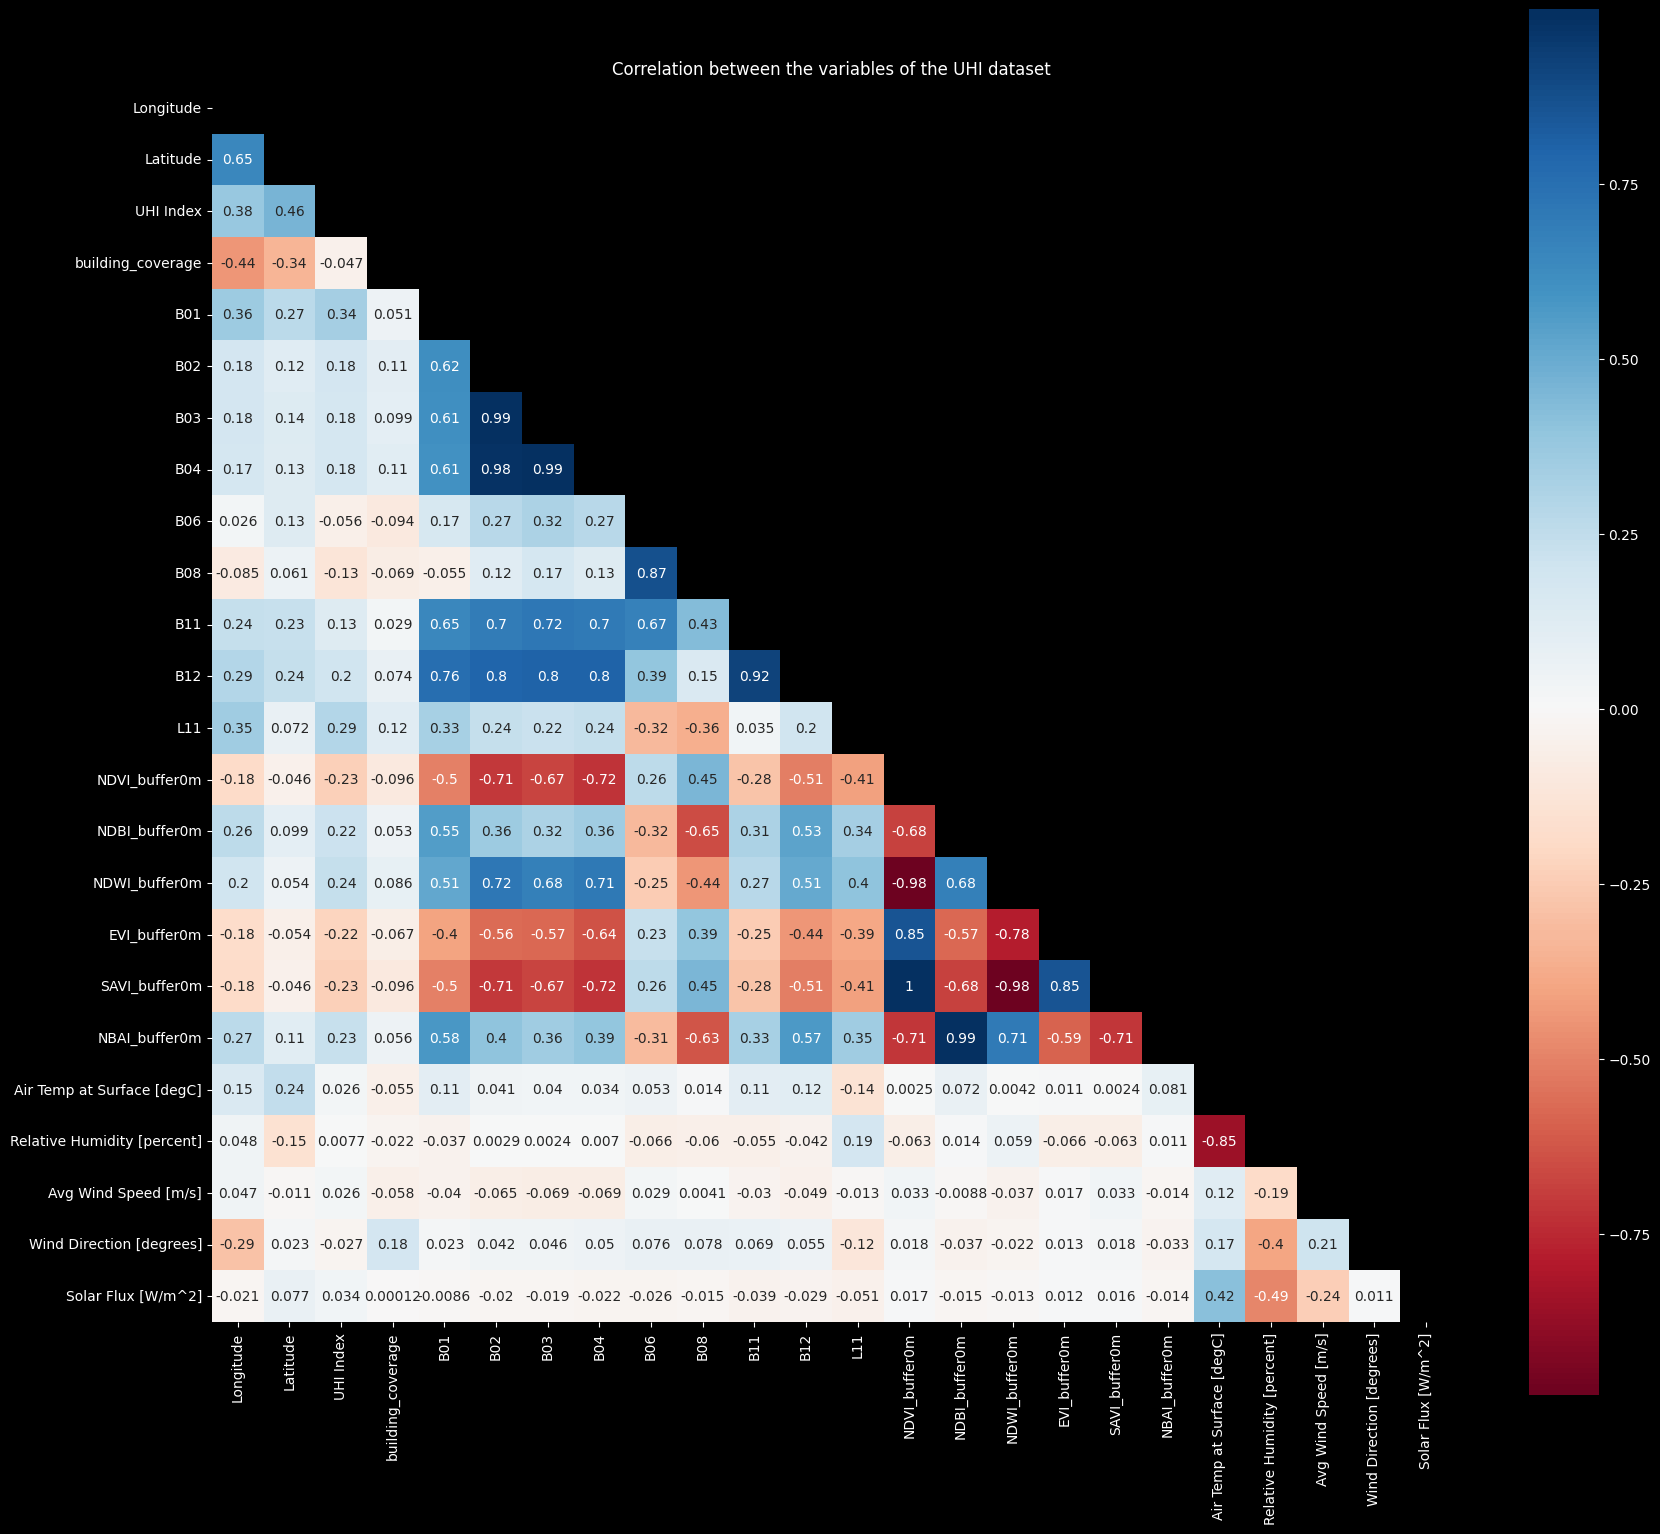

In [44]:
# Calculate correlation between all of the variables using `spearman` method
corr = uhi_data.drop(columns=['datetime', 'location']).corr(method = 'spearman')
corr

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.style.use("dark_background")
plt.subplots
f, ax = plt.subplots(figsize=(20, 18))


# Visualize with a correlation matrix heatmap
sns.heatmap(
    corr,
    annot = True,
    mask = mask,
    center = 0,
    square = True,
    cmap = "RdBu",
    xticklabels = 'auto',
)

plt.title('Correlation between the variables of the UHI dataset',)

In [10]:
uhi_data.to_csv('data/processed/uhi_data.csv', index=False)

## Machine Learning

<h4 style="color:rgb(255, 255, 0)">1. Model training</h4>

- Choose the features and target variable by dropping the unnecessary columns and choosing the UHI index as the target variable.
- Split data with 70/30 ratio, then scale the data
- Droped weather data

In [174]:
# Retaining only the columns for B01, B06, NDVI, and UHI Index in the dataset.
train_data = uhi_data.drop(columns=[
    'Longitude', 'Latitude', 'datetime', 'location', 
    'Air Temp at Surface [degC]','Relative Humidity [percent]', 
    'Avg Wind Speed [m/s]','Wind Direction [degrees]', 'Solar Flux [W/m^2]'
    ])

# Split the data into features (X) and target (y), and then into training and testing sets
X = train_data.drop(columns=['UHI Index'])
y = train_data ['UHI Index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [167]:
# Train the Random Forest model on the training data
model = RandomForestRegressor(
    # bootstrap= False,
    # max_depth= 30,
    # max_features= 'sqrt',
    # min_samples_leaf= 1,
    # min_samples_split= 2,
    # n_estimators= 500
)
model.fit(X_train,y_train)

# 6. Predict on the validation set
y_pred_rf_final = model.predict(X_train)

# 7. Evaluate performance of the final model
#print("MAE train (final RF):", mean_absolute_error(Y_train, y_pred_xgb_final))
print("R² Score train (final RF):", r2_score(y_train, y_pred_rf_final))

# 8. Predict on the validation set
y_pred_rf_final = model.predict(X_test)

# 9. Evaluate performance of the final model
#print("MAE (final RF):", mean_absolute_error(Y_test, y_pred_xgb_final))
print("R² Score (final RF):", r2_score(y_test, y_pred_rf_final))

R² Score train (final RF): 0.9624071765217187
R² Score (final RF): 0.7405023795597422


In [ ]:
# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to hold feature names and their corresponding importance
feature_importance = pd.DataFrame({
    'Feature': train_data.drop(columns=['UHI Index']).columns,  # Assuming train_data is your DataFrame
    'Importance': importances
})

# Sort the features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display the most important features
print(feature_importance.head(5))  # Print top 5 important features

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'][:5], feature_importance['Importance'][:5])
plt.xlabel('Importance')
plt.title('Top 5 Most Important Features (Random Forest)')
plt.show()

In [ ]:
# Get the top 5 important features (change from 8 to 5)
top_5_features = feature_importance['Feature'][:5].tolist()

# Select the columns for the top 5 features from the train_data
X_train_selected = X_train[:, [train_data.drop(columns=['UHI Index']).columns.get_loc(col) for col in top_5_features]]
# Now, for the test data
X_test_selected = X_test[:, [train_data.drop(columns=['UHI Index']).columns.get_loc(col) for col in top_5_features]]

# Train the Random Forest model with the selected features
model_selected = RandomForestRegressor(n_estimators=100, random_state=42)
model_selected.fit(X_train_selected, y_train)

# Make predictions on the training data
insample_predictions = model_selected.predict(X_train_selected)
# Calculate R² score for the in-sample predictions
r2_train = r2_score(y_train, insample_predictions)
print(f"R² Score on Training Data (Top 5 Features): {r2_train}")

# Make predictions on the test data
outsample_predictions = model_selected.predict(X_test_selected)
# Calculate R² score for the out-sample (test) predictions
r2_test = r2_score(y_test, outsample_predictions)
print(f"R² Score on Test Data (Top 5 Features): {r2_test}")

In [186]:
train_data

,UHI Index,building_coverage,building_count,B01,B02,B03,B04,B06,B08,B11,B12,L11,NDVI_buffer0m,NDBI_buffer0m,NDWI_buffer0m,EVI_buffer0m,SAVI_buffer0m,NBAI_buffer0m
0,0.975234,4.248421e-07,7,497.684133,1048.144815,1214.119993,1309.190101,2143.464414,2100.581043,2023.398387,1577.217943,31.819890,0.232095,-0.018716,-0.267433,0.944094,0.348092,0.263109
1,1.000718,2.952757e-06,20,1306.462846,1342.490838,1467.690519,1528.572929,1676.971443,1624.873983,1907.931767,1804.803687,40.265191,0.030538,0.080123,-0.050826,0.330418,0.045800,0.391160
2,1.000718,2.952757e-06,20,1365.268570,1326.530259,1397.509001,1532.360054,1496.982810,1642.376589,1715.895871,1602.931181,40.265191,0.034654,0.021892,-0.080552,0.309536,0.051972,0.337912
3,0.975234,1.083310e-05,22,503.310770,518.144441,651.960854,533.770987,2159.649629,2891.268663,1614.974030,898.178815,33.195535,0.688313,-0.283228,-0.631996,2.668288,1.032318,-0.069964
4,0.970907,4.248421e-07,7,477.914724,405.595662,526.303878,406.072733,2257.066345,2766.147060,1633.047433,872.494684,32.719815,0.743982,-0.257570,-0.680297,2.729525,1.115797,-0.049435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11223,0.975234,1.083310e-05,22,642.350249,1000.734028,1049.912777,1171.531188,1555.903025,1490.832182,1504.484184,1116.975837,35.303569,0.119931,0.004558,-0.173539,0.786058,0.179863,0.274939
11224,0.975234,1.083310e-05,22,642.350249,1000.734028,1049.912777,1171.531188,1555.903025,1490.832182,1504.484184,1116.975837,34.023744,0.119931,0.004558,-0.173539,0.786058,0.179863,0.274939
11225,0.975234,1.083310e-05,22,583.318635,698.080971,802.626734,807.955570,1779.352809,1931.683084,1507.096599,1011.021743,34.023744,0.410174,-0.123470,-0.412922,1.818554,0.615148,0.131789
11227,1.000838,7.459108e-06,84,1080.125142,1271.195267,1197.730408,1234.798035,1699.492800,1605.061120,1821.114970,1692.103169,39.479778,0.130381,0.063060,-0.145330,-1.783145,0.195537,0.372812


A2. Train RF model with GridSearchCV

In [ ]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators':      [100, 200, 300, 500],  # Number of trees in the forest
    'max_depth':         [None, 10, 20, 30, 40],   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
    'min_samples_leaf':  [1, 2, 4],          # Minimum number of samples required at each leaf node
    'max_features':      ['auto', 'sqrt', 'log2'],  # Number of features to consider at every split
    'bootstrap':         [True, False]              # Whether to use bootstrap sampling
}

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Perform GridSearchCV with 5-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Fit the model on the training data
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best Parameters: {grid_search_rf.best_params_}")
print(f"Best Cross-Validation Score: {grid_search_rf.best_score_}")

# Get the best model from grid search
best_rf_model = grid_search_rf.best_estimator_

# 6. Predict on the validation set
y_pred_rf_final = best_rf_model.predict(X_train)
# 7. Evaluate performance of the final model
print("R² Score on train set:", r2_score(y_train, y_pred_rf_final))
# Make predictions with the best model on the test set
outsample_predictions_rf = best_rf_model.predict(X_test)
# 9. Evaluate performance of the final model
print("R² Score on test set:", r2_score(y_test, outsample_predictions_rf))

B1. Train XGB model without tuning

In [175]:
# 4. Initialize the final XGBoost model with the best hyperparameters
model = xgb.XGBRegressor()

# 5. Train the final XGBoost model
model.fit(X_train, y_train)

# 6. Predict on the validation set
y_pred_xgb_final = model.predict(X_train)

# 7. Evaluate performance of the final model
#print("MAE train (final XGBoost):", mean_absolute_error(Y_train, y_pred_xgb_final))
print("R² Score train (final XGBoost):", r2_score(y_train, y_pred_xgb_final))

# 8. Predict on the validation set
y_pred_xgb_final = model.predict(X_test)

# 9. Evaluate performance of the final model
#print("MAE (final XGBoost):", mean_absolute_error(Y_test, y_pred_xgb_final))
print("R² Score (final XGBoost):", r2_score(y_test, y_pred_xgb_final))

R² Score train (final XGBoost): 0.9627384853825589
R² Score (final XGBoost): 0.8113697046043825


B2. Train XGB model with GridSearchCV

In [ ]:
# Define the parameter grid for Random Forest
param_grid_xgb = {
    'max_depth': np.arange(7, 15, 1),              # Best max_depth from tuning
    'subsample': np.linspace(0.5, 1.0, 5),             # Best subsample from tuning
    'min_child_weight': np.arange(0, 5, 1),        # Best min_child_weight from tuning
    'colsample_bytree': np.linspace(0.5, 1.0, 5),      # Best colsample_bytree from tuning
    'learning_rate': np.linspace(0.01, 0.5, 20),        # Best learning_rate from tuning
    'n_estimators': [100, 300, 500],           # Keep the number of estimators 
}

# Initialize the XGB model
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    eval_metric="rmse"
)

# Perform GridSearchCV with 5-fold cross-validation
grid_search_xgb = GridSearchCV(
    estimator=xgb_model, param_grid=param_grid_xgb, 
    cv=5, scoring='r2', n_jobs=-1, verbose=1
)

# Fit the model on the training data
grid_search_xgb.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best Parameters: {grid_search_xgb.best_params_}")
print(f"Best Cross-Validation Score: {grid_search_xgb.best_score_}")

# Get the best model from grid search
best_xgb_model = grid_search_xgb.best_estimator_

# 6. Predict on the validation set
y_pred_xgb_final = best_xgb_model.predict(X_train)
# 7. Evaluate performance of the final model
print("R² Score on train set:", r2_score(y_train, y_pred_xgb_final))
# Make predictions with the best model on the test set
outsample_predictions_xgb = best_xgb_model.predict(X_test)
# 9. Evaluate performance of the final model
print("R² Score on test set:", r2_score(y_test, outsample_predictions_xgb))

B3. Train XGB model by hand

In [ ]:
# Get the best model from grid search
manual_xgb = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=42,
    colsample_bytree=1,
    learning_rate=0.05,
    max_depth=9,
    min_child_weight=3,
    n_estimators=500,
    subsample=1,
    #reg_lambda=10,
    #reg_alpha=0.005
)

# Fit the model on the training data
manual_xgb.fit(X_train, y_train)

# 6. Predict on the validation set
y_pred_xgb_final = manual_xgb.predict(X_train)
# 7. Evaluate performance of the final model
print("R² Score on train set:", round(r2_score(y_train, y_pred_xgb_final),4))

# Make predictions with the best model on the test set
outsample_predictions_xgb = manual_xgb.predict(X_test)
# 9. Evaluate performance of the final model
print(
    "R² Score on test set:", 
    round(
        r2_score(y_test, outsample_predictions_xgb), 4
    )
)
print(
    "train-test difference:", 
    round(
        r2_score(y_train, y_pred_xgb_final) - r2_score(y_test, outsample_predictions_xgb), 4
    )
)

R² Score on train set: 0.991
R² Score on test set: 0.851
train-test difference: 0.14


C. RF with Ridge

In [ ]:
from sklearn.linear_model import Ridge
import numpy as np

# Train Ridge Regression
ridge = Ridge(alpha=0.1)  # You can tune alpha for better results
ridge.fit(X_train, y_train)

# Get feature importance (absolute values of coefficients)
feature_importance = np.abs(ridge.coef_)
# Map feature importance to column names
feature_importance_dict = dict(zip(train_data.drop(columns=['UHI Index']).columns, feature_importance))
# Sort features by importance (descending order)
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print feature importance
print("Feature Importance from Ridge Regression:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

# Select the top 15 important features based on Ridge
top_features_ridge = [feature for feature, _ in sorted_features[:15]]
print("Top 15 Features Selected by Ridge:", top_features_ridge)

# Filter the dataset to only include selected features
X_train_selected = X_train[:, [list(train_data.drop(columns=['UHI Index']).columns).index(col) for col in top_features_ridge]]
X_test_selected = X_test[:, [list(train_data.drop(columns=['UHI Index']).columns).index(col) for col in top_features_ridge]]

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Train the Random Forest model with selected features
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

# Predict and evaluate
r2_train_rf = r2_score(y_train, rf_model.predict(X_train_selected))
r2_test_rf = r2_score(y_test, rf_model.predict(X_test_selected))

print(f"R² Score on Training Data (RF with Ridge Features): {r2_train_rf}")
print(f"R² Score on Test Data (RF with Ridge Features): {r2_test_rf}")


from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_selected, y_train)

print(grid_search.best_params_)

Feature Importance from Ridge Regression:
B03: 0.01521221864064093
B04: 0.011168859094286094
B11: 0.009459613278621102
NDWI: 0.006480907732898977
B02: 0.006296589108695501
B12: 0.006183500773956748
NDVI: 0.005238278537584541
SAVI: 0.004584198466722552
B01: 0.004196495935148993
L11: 0.00411594382182063
NDBI: 0.0036414643182049416
NBAI: 0.003447864507402405
B06: 0.0030677485501121905
B08: 0.0019107684223272812
building_coverage: 0.001684670918749047
EVI: 0.0002730584354992669
Top 15 Features Selected by Ridge: ['B03', 'B04', 'B11', 'NDWI', 'B02', 'B12', 'NDVI', 'SAVI', 'B01', 'L11', 'NDBI', 'NBAI', 'B06', 'B08', 'building_coverage']
R² Score on Training Data (RF with Ridge Features): 0.964627889712154
R² Score on Test Data (RF with Ridge Features): 0.7579462346511695
{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [21]:
# Train the Random Forest model with selected features
rf_model = RandomForestRegressor(
    max_depth=15,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100
)
rf_model.fit(X_train_selected, y_train)

# Predict and evaluate
r2_train_rf = r2_score(y_train, rf_model.predict(X_train_selected))
r2_test_rf = r2_score(y_test, rf_model.predict(X_test_selected))

print(f"R² Score on Training Data (RF with Ridge Features): {r2_train_rf}")
print(f"R² Score on Test Data (RF with Ridge Features): {r2_test_rf}")

R² Score on Training Data (RF with Ridge Features): 0.9060742816206214
R² Score on Test Data (RF with Ridge Features): 0.7214323716928798


<h4 style="color:rgb(255, 255, 0)">2. Feature evaluation</h4>

Evaluate feature importance with SHAP

In [ ]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer.shap_values(X_test)  # X_test is your test dataset

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)

In [178]:
# Reading the coordinates for the submission
test_file = pd.read_csv('data/test/Submission_template.csv')

band_mappings = {
    "B01": ("sentinel", 1),
    "B02": ("sentinel", 2),
    "B03": ("sentinel", 3),
    "B04": ("sentinel", 4),
    #"B05": ("sentinel", 5),
    "B06": ("sentinel", 5),
    #"B07": ("sentinel", 7),
    #"B8A": ("sentinel", 8),
    "B08": ("sentinel", 6),
    "B11": ("sentinel", 7),
    "B12": ("sentinel", 8),
    "L11": ("landsat", 1)
}

buffer_sizes = [0, 10, 20, 30, 50, 100]


# Run the pipeline
manipulator = SatelliteDataManipulator(
    sen2_tiff_path="data/interim/Sen2.tiff",
    land_tiff_path="data/interim/Landsat_LST.tiff",
    ground_df_path="data/test/Submission_template.csv",
    band_mappings=band_mappings,
    buffer_distances=[0],
)

val_data = manipulator.map_satellite_data()
val_data = manipulator.calc_band_indices(val_data)

# Load ground dataset
test_ground_df = pd.read_csv("data/interim/test_ground_df.csv")

Loading GeoTIFF data...
Data loaded!
Loading ground truth data...
Data loaded!


Mapping values: 100%|██████████| 1040/1040 [00:02<00:00, 391.73it/s]


In [179]:
# Simply use `pd.concat` as we've already get the data based on each lon & lat of ground_df
test_data = pd.concat([test_ground_df,val_data], axis=1)

In [ ]:

# Apply function to dataset
# test_satground_df['location'] = test_satground_df.apply(lambda row: classify_location(row['Latitude'], row['Longitude']), axis=1)
# Make a copy to merge weather data
#test_satground_df2 = test_satground_df.copy()

# # Convert satground_df to datetime dtype
# test_satground_df2['datetime'] = pd.to_datetime(test_satground_df2['datetime'], format='%d-%m-%Y %H:%M')
# # Ensure all DataFrames are sorted by datetime
# test_satground_df2 = test_satground_df2.sort_values('datetime')
# # Merge using 'Datetime' and 'location'
# test_data = pd.merge_asof(test_satground_df2, weather_df, on='datetime', by='location')
# # Check the final DataFrame
# test_data.head()

# Calculate average weather data for each location
# weather_mean = weather_df.groupby(['location']).mean().reset_index()
# Merge using 'Datetime' and 'location'
# test_data = pd.merge(test_satground_df2, weather_mean, how='left',on='location')

#test_data = test_satground_df2

In [180]:
test_set = test_data.drop([
    'Longitude', 'Latitude', 'UHI Index', 
    #'location',
    #'datetime'
    ], 
    axis=1
)
test_set = sc.transform(test_set)

In [182]:
final_predictions = manual_xgb.predict(test_set)
final_prediction_series = pd.Series(final_predictions)

In [183]:
#Combining the results into dataframe
submission_df = pd.DataFrame(
    {
        'Longitude':test_file['Longitude'].values, 
        'Latitude':test_file['Latitude'].values, 
        'UHI Index':final_prediction_series.values}
)

#Dumping the predictions into a csv file.
submission_df.to_csv("submission.csv",index = False)